In [1]:
import torch as tch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
# from google.colab import drive
# import os, sys

# drive.mount('/content/mnt')
# nb_path = '/content/notebooks'
# os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0, nb_path)

In [2]:
#!ls drive/My\ Drive/Colab\ Notebooks

 fastai_01_cat_dog.ipynb   rotation.ipynb	 snn_rot3.pt
 Polar.ipynb		   rotation_load.ipynb	 snn_rot.pt
'PyTorch Tutorial.ipynb'   snn_rot2.pt		 Untitled0.ipynb


In [2]:
device = 'cuda' if tch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
pi = tch.tensor(math.pi).float().to(device)
pi

tensor(3.1416)

In [4]:
def rotate(X, theta):
    R = tch.tensor([[tch.cos(theta), tch.sin(theta)], [-tch.sin(theta), tch.cos(theta)]]).float().to(device)
    return tch.mm(X, R)

In [5]:
# Generate Positive Datasets
X = tch.randn(1000, 2).float().to(device)
thetas = tch.randn(1000).to(device) * pi
X_p = tch.empty((1000, 2))
for i, (x, th) in enumerate(zip(X, thetas)):
    R = tch.tensor([[tch.cos(th), tch.sin(th)], [-tch.sin(th), tch.cos(th)]]).float().to(device)
    x_p = tch.mm(x.view(1,2), R)
    X_p[i] = x_p

In [6]:
X

tensor([[ 1.9462, -1.1236],
        [-0.5422,  0.6724],
        [ 1.5106, -0.8925],
        ...,
        [-1.5470,  0.6077],
        [ 0.1673, -1.2980],
        [ 0.2038,  2.0247]])

In [7]:
X_p

tensor([[-2.1985,  0.4659],
        [-0.6710, -0.5439],
        [-1.5729,  0.7776],
        ...,
        [-1.1958, -1.1543],
        [-0.3065,  1.2724],
        [ 1.8987, -0.7321]])

In [8]:
# Generate Negative Datasets
r_perm = tch.randperm(X_p.shape[0])
X_n = tch.column_stack([X_p[:,0], X_p[r_perm, 1]])

In [9]:
X_n

tensor([[-2.1985,  0.3829],
        [-0.6710, -0.5716],
        [-1.5729,  1.0014],
        ...,
        [-1.1958, -1.1236],
        [-0.3065,  1.7846],
        [ 1.8987,  1.4636]])

In [10]:
# Generate Positive Datasets for Test
X_test = tch.randn(100, 2).float().to(device)
thetas_test = tch.randn(100).to(device) * pi
X_p_test = tch.empty((100, 2))
for i, (x, th) in enumerate(zip(X_test, thetas_test)):
    R = tch.tensor([[tch.cos(th), tch.sin(th)], [-tch.sin(th), tch.cos(th)]]).float().to(device)
    x_p = tch.mm(x.view(1,2), R)
    X_p_test[i] = x_p

# Generate Negative Datasets for Test
r_perm_test = tch.randperm(X_p_test.shape[0])
X_n_test = tch.column_stack([X_p_test[:,0], X_p_test[r_perm_test, 1]]) 

In [11]:
X_test[:5,:]

tensor([[ 1.2213,  0.5487],
        [-0.4644,  0.4810],
        [ 0.8027, -1.1023],
        [-1.1636, -0.7621],
        [-1.3347,  0.1937]])

In [12]:
X_p_test[:5,:]

tensor([[ 0.3835,  1.2828],
        [ 0.4595,  0.4858],
        [ 1.3553, -0.1503],
        [-0.1264, -1.3851],
        [-0.7896,  1.0933]])

In [13]:
X_n_test[:5,:]

tensor([[ 0.3835,  0.5273],
        [ 0.4595,  1.5110],
        [ 1.3553,  2.0688],
        [-0.1264, -0.1503],
        [-0.7896, -0.9787]])

In [14]:
# Labeling
y_p = tch.zeros((X_p.shape[0], 1))
y_n = tch.ones((X_n.shape[0], 1))
y = tch.vstack([y_p, y_n])
y

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

In [15]:
# Labeling for Test
y_p_test = tch.zeros((X_p_test.shape[0], 1))
y_n_test = tch.ones((X_n_test.shape[0], 1))
y_test = tch.vstack([y_p_test, y_n_test])
y_test[:5,:]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [16]:
class RotationDataset(Dataset):
    def __init__(self, size):
        # Generate Positive Datasets
        unif1 = Uniform(0.1, 1)
        unif2 = Uniform(0, 2*math.pi)
        unif3 = Uniform(0, 2*math.pi)
        r = unif1.sample([size]).float()
        th = unif2.sample([size]).float()
        self.X = tch.column_stack([r*tch.cos(th), r*tch.sin(th)])
        thetas = unif3.sample([size]).float()
        X_p = tch.empty((size, 2))
        for i, (x, th) in enumerate(zip(self.X, thetas)):
            R = tch.tensor([[tch.cos(th), tch.sin(th)], [-tch.sin(th), tch.cos(th)]]).float()
            x_p = tch.mm(x.view(1,2), R)
            X_p[i] = x_p
        
        # Generate Negative Datasets
        r_perm = tch.randperm(X_p.shape[0])
        X_n = tch.column_stack([X_p[:,0], X_p[r_perm, 1]])

        # Stack Pairs
        self.X_pairs = tch.vstack([X_p, X_n])
        self.X = tch.vstack([self.X, self.X])

        # Labeling
        y_p = tch.zeros((X_p.shape[0], 1))
        y_n = tch.ones((X_n.shape[0], 1))
        self.y = tch.vstack([y_p, y_n])

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = tch.Tensor(self.X[idx])
        x_pair = tch.Tensor(self.X_pairs[idx])
        y = tch.Tensor(self.y[idx])
        return x, x_pair, y

In [17]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(2,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.ReLU()
        )

    def forward(self, x1, x2):
        out1 = self.linear_relu(x1)
        out2 = self.linear_relu(x2)
        return out1, out2

In [18]:
class ContrastiveLoss(tch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = tch.mean((1-label) * tch.pow(euclidean_distance, 2) +
                                      (label) * tch.pow(tch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [19]:
net = SNN().to(device)
print(net)

SNN(
  (linear_relu): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): ReLU()
  )
)


In [20]:
loss_fn = ContrastiveLoss()
optimizer = tch.optim.Adam(net.parameters(), lr=1e-3)

In [21]:
train_dataset = RotationDataset(100000)
valid_dataset = RotationDataset(10000)
test_dataset = RotationDataset(10000)

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=200, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=200, shuffle=True)

In [23]:
for _, samples in enumerate(test_dataloader):
    x, x_p, y = samples
    temp = tch.column_stack([x, x_p, y])
    print(temp[:5, :])
    break

tensor([[-0.1445, -0.7367,  0.7507,  0.0063,  0.0000],
        [ 0.2755, -0.0420,  0.2226,  0.1677,  0.0000],
        [-0.1357,  0.0594,  0.0624, -0.1272,  1.0000],
        [ 0.0684,  0.6388, -0.4925, -0.4125,  0.0000],
        [-0.2849,  0.1675, -0.1579, -0.2903,  0.0000]])


In [24]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = []
    for batch, samples in enumerate(dataloader):
        X, X_p, y = samples
        X, X_p, y = X.to(device), X_p.to(device), y.to(device)

        pred1, pred2 = model(X, X_p)
        loss = loss_fn(pred1, pred2, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * X.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_loss.append(loss)
        
    return tch.mean(tch.tensor(train_loss).float().to(device))

In [25]:
def validity_check(dataloader, model, loss_fn, dist=1):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with tch.no_grad():
        for X, X_p, y in dataloader:
            X, X_p, y = X.to(device), X_p.to(device), y.to(device)
            pred1, pred2 = model(X, X_p)
            test_loss += loss_fn(pred1, pred2, y).item()
            correct += tch.count_nonzero((tch.abs(pred1 - pred2) <= dist) != y).item()
    test_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    # print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [26]:
epochs = 1000
train_loss= []
valid_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train(train_dataloader, net, loss_fn, optimizer))
    validity, correct = validity_check(valid_dataloader, net, loss_fn, 0.25)
    valid_loss.append(validity)
    if correct == 1:
        break
print("Done!")

Epoch 1
-------------------------------
loss: 1.942831  [    0/200000]
loss: 1.407961  [50000/200000]
loss: 1.293509  [100000/200000]
loss: 1.336809  [150000/200000]
Validation Error: 
 Accuracy: 54.3%, Avg loss: 1.331422 

Epoch 2
-------------------------------
loss: 1.412001  [    0/200000]
loss: 1.296108  [50000/200000]
loss: 1.435225  [100000/200000]
loss: 1.385999  [150000/200000]
Validation Error: 
 Accuracy: 53.5%, Avg loss: 1.316505 

Epoch 3
-------------------------------
loss: 1.274309  [    0/200000]
loss: 1.280506  [50000/200000]
loss: 1.274513  [100000/200000]
loss: 0.923714  [150000/200000]
Validation Error: 
 Accuracy: 69.5%, Avg loss: 0.716302 

Epoch 4
-------------------------------
loss: 0.742993  [    0/200000]
loss: 0.670518  [50000/200000]
loss: 0.509184  [100000/200000]
loss: 0.480281  [150000/200000]
Validation Error: 
 Accuracy: 83.2%, Avg loss: 0.436985 

Epoch 5
-------------------------------
loss: 0.398896  [    0/200000]
loss: 0.375359  [50000/200000]
lo

loss: 0.121409  [100000/200000]
loss: 0.121294  [150000/200000]
Validation Error: 
 Accuracy: 97.2%, Avg loss: 0.120040 

Epoch 38
-------------------------------
loss: 0.139423  [    0/200000]
loss: 0.169180  [50000/200000]
loss: 0.151653  [100000/200000]
loss: 0.163722  [150000/200000]
Validation Error: 
 Accuracy: 98.1%, Avg loss: 0.116966 

Epoch 39
-------------------------------
loss: 0.112260  [    0/200000]
loss: 0.126335  [50000/200000]
loss: 0.076088  [100000/200000]
loss: 0.129297  [150000/200000]
Validation Error: 
 Accuracy: 98.0%, Avg loss: 0.116041 

Epoch 40
-------------------------------
loss: 0.126953  [    0/200000]
loss: 0.111888  [50000/200000]
loss: 0.113670  [100000/200000]
loss: 0.114401  [150000/200000]
Validation Error: 
 Accuracy: 97.2%, Avg loss: 0.116006 

Epoch 41
-------------------------------
loss: 0.118921  [    0/200000]
loss: 0.133598  [50000/200000]
loss: 0.122539  [100000/200000]
loss: 0.153139  [150000/200000]
Validation Error: 
 Accuracy: 98.4%,

loss: 0.074894  [50000/200000]
loss: 0.093265  [100000/200000]
loss: 0.103509  [150000/200000]
Validation Error: 
 Accuracy: 98.9%, Avg loss: 0.085955 

Epoch 75
-------------------------------
loss: 0.085690  [    0/200000]
loss: 0.108277  [50000/200000]
loss: 0.088896  [100000/200000]
loss: 0.080566  [150000/200000]
Validation Error: 
 Accuracy: 98.1%, Avg loss: 0.088478 

Epoch 76
-------------------------------
loss: 0.127252  [    0/200000]
loss: 0.101399  [50000/200000]
loss: 0.086690  [100000/200000]
loss: 0.106308  [150000/200000]
Validation Error: 
 Accuracy: 98.9%, Avg loss: 0.085009 

Epoch 77
-------------------------------
loss: 0.105869  [    0/200000]
loss: 0.061726  [50000/200000]
loss: 0.089425  [100000/200000]
loss: 0.095920  [150000/200000]
Validation Error: 
 Accuracy: 98.3%, Avg loss: 0.085775 

Epoch 78
-------------------------------
loss: 0.089004  [    0/200000]
loss: 0.080988  [50000/200000]
loss: 0.117494  [100000/200000]
loss: 0.081519  [150000/200000]
Valid

Validation Error: 
 Accuracy: 98.9%, Avg loss: 0.073096 

Epoch 111
-------------------------------
loss: 0.049842  [    0/200000]
loss: 0.106775  [50000/200000]
loss: 0.086018  [100000/200000]
loss: 0.098049  [150000/200000]
Validation Error: 
 Accuracy: 99.0%, Avg loss: 0.072467 

Epoch 112
-------------------------------
loss: 0.068487  [    0/200000]
loss: 0.079466  [50000/200000]
loss: 0.098867  [100000/200000]
loss: 0.093358  [150000/200000]
Validation Error: 
 Accuracy: 98.8%, Avg loss: 0.072311 

Epoch 113
-------------------------------
loss: 0.056846  [    0/200000]
loss: 0.133159  [50000/200000]
loss: 0.040693  [100000/200000]
loss: 0.067000  [150000/200000]
Validation Error: 
 Accuracy: 99.1%, Avg loss: 0.072588 

Epoch 114
-------------------------------
loss: 0.053126  [    0/200000]
loss: 0.081576  [50000/200000]
loss: 0.099068  [100000/200000]
loss: 0.073080  [150000/200000]
Validation Error: 
 Accuracy: 99.0%, Avg loss: 0.071877 

Epoch 115
----------------------------

loss: 0.102424  [50000/200000]
loss: 0.063923  [100000/200000]
loss: 0.072929  [150000/200000]
Validation Error: 
 Accuracy: 98.9%, Avg loss: 0.065899 

Epoch 148
-------------------------------
loss: 0.106023  [    0/200000]
loss: 0.079960  [50000/200000]
loss: 0.077387  [100000/200000]
loss: 0.068859  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.064754 

Epoch 149
-------------------------------
loss: 0.078393  [    0/200000]
loss: 0.038008  [50000/200000]
loss: 0.078913  [100000/200000]
loss: 0.026144  [150000/200000]
Validation Error: 
 Accuracy: 99.1%, Avg loss: 0.064684 

Epoch 150
-------------------------------
loss: 0.092378  [    0/200000]
loss: 0.058032  [50000/200000]
loss: 0.039931  [100000/200000]
loss: 0.090443  [150000/200000]
Validation Error: 
 Accuracy: 98.7%, Avg loss: 0.066368 

Epoch 151
-------------------------------
loss: 0.052822  [    0/200000]
loss: 0.066976  [50000/200000]
loss: 0.059727  [100000/200000]
loss: 0.087481  [150000/200000]
V

loss: 0.062601  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.059073 

Epoch 184
-------------------------------
loss: 0.060035  [    0/200000]
loss: 0.056537  [50000/200000]
loss: 0.068968  [100000/200000]
loss: 0.066770  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.059177 

Epoch 185
-------------------------------
loss: 0.051579  [    0/200000]
loss: 0.082385  [50000/200000]
loss: 0.079238  [100000/200000]
loss: 0.063626  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.058847 

Epoch 186
-------------------------------
loss: 0.062396  [    0/200000]
loss: 0.059276  [50000/200000]
loss: 0.072096  [100000/200000]
loss: 0.046034  [150000/200000]
Validation Error: 
 Accuracy: 99.0%, Avg loss: 0.060045 

Epoch 187
-------------------------------
loss: 0.078491  [    0/200000]
loss: 0.072920  [50000/200000]
loss: 0.059266  [100000/200000]
loss: 0.063282  [150000/200000]
Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.059056 

Epoch 

loss: 0.048313  [50000/200000]
loss: 0.052257  [100000/200000]
loss: 0.093928  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.055407 

Epoch 221
-------------------------------
loss: 0.048890  [    0/200000]
loss: 0.079420  [50000/200000]
loss: 0.033952  [100000/200000]
loss: 0.049930  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.054817 

Epoch 222
-------------------------------
loss: 0.041941  [    0/200000]
loss: 0.047643  [50000/200000]
loss: 0.020177  [100000/200000]
loss: 0.058583  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.055159 

Epoch 223
-------------------------------
loss: 0.033703  [    0/200000]
loss: 0.041091  [50000/200000]
loss: 0.048099  [100000/200000]
loss: 0.064101  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.055202 

Epoch 224
-------------------------------
loss: 0.070090  [    0/200000]
loss: 0.047109  [50000/200000]
loss: 0.076600  [100000/200000]
loss: 0.043932  [150000/200000]
V

loss: 0.081494  [150000/200000]
Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.052800 

Epoch 257
-------------------------------
loss: 0.095682  [    0/200000]
loss: 0.056029  [50000/200000]
loss: 0.059058  [100000/200000]
loss: 0.055460  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.051028 

Epoch 258
-------------------------------
loss: 0.028970  [    0/200000]
loss: 0.071946  [50000/200000]
loss: 0.037368  [100000/200000]
loss: 0.056605  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.051201 

Epoch 259
-------------------------------
loss: 0.060484  [    0/200000]
loss: 0.050241  [50000/200000]
loss: 0.024594  [100000/200000]
loss: 0.041841  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.051105 

Epoch 260
-------------------------------
loss: 0.058985  [    0/200000]
loss: 0.096263  [50000/200000]
loss: 0.042893  [100000/200000]
loss: 0.065785  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.050890 

Epoch 

loss: 0.088293  [50000/200000]
loss: 0.071944  [100000/200000]
loss: 0.069355  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.048919 

Epoch 294
-------------------------------
loss: 0.038573  [    0/200000]
loss: 0.061161  [50000/200000]
loss: 0.064933  [100000/200000]
loss: 0.062865  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.048852 

Epoch 295
-------------------------------
loss: 0.046585  [    0/200000]
loss: 0.075578  [50000/200000]
loss: 0.055810  [100000/200000]
loss: 0.050863  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.049409 

Epoch 296
-------------------------------
loss: 0.053804  [    0/200000]
loss: 0.075854  [50000/200000]
loss: 0.050202  [100000/200000]
loss: 0.061655  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.048558 

Epoch 297
-------------------------------
loss: 0.086579  [    0/200000]
loss: 0.063852  [50000/200000]
loss: 0.047711  [100000/200000]
loss: 0.064378  [150000/200000]
V

loss: 0.073961  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.046799 

Epoch 330
-------------------------------
loss: 0.054596  [    0/200000]
loss: 0.043172  [50000/200000]
loss: 0.054224  [100000/200000]
loss: 0.045465  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.047430 

Epoch 331
-------------------------------
loss: 0.034411  [    0/200000]
loss: 0.043695  [50000/200000]
loss: 0.063410  [100000/200000]
loss: 0.071099  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.046503 

Epoch 332
-------------------------------
loss: 0.064816  [    0/200000]
loss: 0.058515  [50000/200000]
loss: 0.027870  [100000/200000]
loss: 0.049906  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.046291 

Epoch 333
-------------------------------
loss: 0.048401  [    0/200000]
loss: 0.066612  [50000/200000]
loss: 0.053725  [100000/200000]
loss: 0.067170  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.046401 

Epoch 

loss: 0.073634  [50000/200000]
loss: 0.033598  [100000/200000]
loss: 0.069987  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.045594 

Epoch 367
-------------------------------
loss: 0.056667  [    0/200000]
loss: 0.040139  [50000/200000]
loss: 0.063553  [100000/200000]
loss: 0.046188  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.045190 

Epoch 368
-------------------------------
loss: 0.045922  [    0/200000]
loss: 0.090179  [50000/200000]
loss: 0.035269  [100000/200000]
loss: 0.038607  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.044562 

Epoch 369
-------------------------------
loss: 0.062697  [    0/200000]
loss: 0.030440  [50000/200000]
loss: 0.031237  [100000/200000]
loss: 0.047634  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.045145 

Epoch 370
-------------------------------
loss: 0.080515  [    0/200000]
loss: 0.073967  [50000/200000]
loss: 0.046167  [100000/200000]
loss: 0.040780  [150000/200000]
V

loss: 0.040690  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.043431 

Epoch 403
-------------------------------
loss: 0.035362  [    0/200000]
loss: 0.039172  [50000/200000]
loss: 0.037906  [100000/200000]
loss: 0.062360  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.043245 

Epoch 404
-------------------------------
loss: 0.048713  [    0/200000]
loss: 0.049742  [50000/200000]
loss: 0.036130  [100000/200000]
loss: 0.050157  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.043076 

Epoch 405
-------------------------------
loss: 0.034006  [    0/200000]
loss: 0.067277  [50000/200000]
loss: 0.054900  [100000/200000]
loss: 0.028395  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.043585 

Epoch 406
-------------------------------
loss: 0.053442  [    0/200000]
loss: 0.049133  [50000/200000]
loss: 0.044712  [100000/200000]
loss: 0.030331  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.043059 

Epoch 

loss: 0.048826  [50000/200000]
loss: 0.036492  [100000/200000]
loss: 0.059752  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.041367 

Epoch 440
-------------------------------
loss: 0.030417  [    0/200000]
loss: 0.063652  [50000/200000]
loss: 0.045599  [100000/200000]
loss: 0.031996  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.041565 

Epoch 441
-------------------------------
loss: 0.017930  [    0/200000]
loss: 0.057876  [50000/200000]
loss: 0.056090  [100000/200000]
loss: 0.038697  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.042358 

Epoch 442
-------------------------------
loss: 0.043386  [    0/200000]
loss: 0.053317  [50000/200000]
loss: 0.039825  [100000/200000]
loss: 0.020340  [150000/200000]
Validation Error: 
 Accuracy: 98.8%, Avg loss: 0.043591 

Epoch 443
-------------------------------
loss: 0.030859  [    0/200000]
loss: 0.040356  [50000/200000]
loss: 0.049047  [100000/200000]
loss: 0.055665  [150000/200000]
V

loss: 0.044819  [150000/200000]
Validation Error: 
 Accuracy: 99.0%, Avg loss: 0.042103 

Epoch 476
-------------------------------
loss: 0.096064  [    0/200000]
loss: 0.053548  [50000/200000]
loss: 0.056527  [100000/200000]
loss: 0.041755  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.040582 

Epoch 477
-------------------------------
loss: 0.049817  [    0/200000]
loss: 0.068104  [50000/200000]
loss: 0.073982  [100000/200000]
loss: 0.044279  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.041300 

Epoch 478
-------------------------------
loss: 0.034590  [    0/200000]
loss: 0.037352  [50000/200000]
loss: 0.040303  [100000/200000]
loss: 0.036435  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.040328 

Epoch 479
-------------------------------
loss: 0.042237  [    0/200000]
loss: 0.038004  [50000/200000]
loss: 0.038313  [100000/200000]
loss: 0.057623  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.041091 

Epoch 

loss: 0.063709  [50000/200000]
loss: 0.019124  [100000/200000]
loss: 0.031783  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.039299 

Epoch 513
-------------------------------
loss: 0.044610  [    0/200000]
loss: 0.038011  [50000/200000]
loss: 0.056841  [100000/200000]
loss: 0.063734  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.040129 

Epoch 514
-------------------------------
loss: 0.040177  [    0/200000]
loss: 0.047313  [50000/200000]
loss: 0.031389  [100000/200000]
loss: 0.032709  [150000/200000]
Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.040371 

Epoch 515
-------------------------------
loss: 0.030637  [    0/200000]
loss: 0.063613  [50000/200000]
loss: 0.027563  [100000/200000]
loss: 0.042959  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.039705 

Epoch 516
-------------------------------
loss: 0.058761  [    0/200000]
loss: 0.045435  [50000/200000]
loss: 0.056629  [100000/200000]
loss: 0.025150  [150000/200000]
V

loss: 0.031169  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.039114 

Epoch 549
-------------------------------
loss: 0.082411  [    0/200000]
loss: 0.065774  [50000/200000]
loss: 0.026107  [100000/200000]
loss: 0.041241  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.038240 

Epoch 550
-------------------------------
loss: 0.040759  [    0/200000]
loss: 0.032110  [50000/200000]
loss: 0.040594  [100000/200000]
loss: 0.054763  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.039114 

Epoch 551
-------------------------------
loss: 0.037315  [    0/200000]
loss: 0.054043  [50000/200000]
loss: 0.015411  [100000/200000]
loss: 0.055276  [150000/200000]
Validation Error: 
 Accuracy: 99.1%, Avg loss: 0.039855 

Epoch 552
-------------------------------
loss: 0.034214  [    0/200000]
loss: 0.056240  [50000/200000]
loss: 0.031697  [100000/200000]
loss: 0.074999  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.038990 

Epoch 

loss: 0.039067  [50000/200000]
loss: 0.033652  [100000/200000]
loss: 0.029399  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.037648 

Epoch 586
-------------------------------
loss: 0.038911  [    0/200000]
loss: 0.053354  [50000/200000]
loss: 0.037073  [100000/200000]
loss: 0.048622  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.038065 

Epoch 587
-------------------------------
loss: 0.054420  [    0/200000]
loss: 0.075522  [50000/200000]
loss: 0.041889  [100000/200000]
loss: 0.050741  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.037738 

Epoch 588
-------------------------------
loss: 0.036938  [    0/200000]
loss: 0.031676  [50000/200000]
loss: 0.073182  [100000/200000]
loss: 0.055723  [150000/200000]
Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.038574 

Epoch 589
-------------------------------
loss: 0.023368  [    0/200000]
loss: 0.045280  [50000/200000]
loss: 0.041338  [100000/200000]
loss: 0.058546  [150000/200000]
V

loss: 0.047838  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.036692 

Epoch 622
-------------------------------
loss: 0.056217  [    0/200000]
loss: 0.045004  [50000/200000]
loss: 0.026583  [100000/200000]
loss: 0.030694  [150000/200000]
Validation Error: 
 Accuracy: 98.6%, Avg loss: 0.039507 

Epoch 623
-------------------------------
loss: 0.038398  [    0/200000]
loss: 0.018315  [50000/200000]
loss: 0.034152  [100000/200000]
loss: 0.045793  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.036626 

Epoch 624
-------------------------------
loss: 0.042920  [    0/200000]
loss: 0.032882  [50000/200000]
loss: 0.038006  [100000/200000]
loss: 0.032788  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.036742 

Epoch 625
-------------------------------
loss: 0.018754  [    0/200000]
loss: 0.037492  [50000/200000]
loss: 0.034374  [100000/200000]
loss: 0.063085  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.037222 

Epoch 

loss: 0.040397  [50000/200000]
loss: 0.050884  [100000/200000]
loss: 0.051765  [150000/200000]
Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.036891 

Epoch 659
-------------------------------
loss: 0.043910  [    0/200000]
loss: 0.037275  [50000/200000]
loss: 0.058455  [100000/200000]
loss: 0.031163  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.035843 

Epoch 660
-------------------------------
loss: 0.033640  [    0/200000]
loss: 0.049006  [50000/200000]
loss: 0.024416  [100000/200000]
loss: 0.020776  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.036407 

Epoch 661
-------------------------------
loss: 0.038432  [    0/200000]
loss: 0.058436  [50000/200000]
loss: 0.053250  [100000/200000]
loss: 0.034195  [150000/200000]
Validation Error: 
 Accuracy: 97.7%, Avg loss: 0.040212 

Epoch 662
-------------------------------
loss: 0.054853  [    0/200000]
loss: 0.022417  [50000/200000]
loss: 0.022981  [100000/200000]
loss: 0.044151  [150000/200000]
V

loss: 0.053938  [150000/200000]
Validation Error: 
 Accuracy: 98.2%, Avg loss: 0.039397 

Epoch 695
-------------------------------
loss: 0.029628  [    0/200000]
loss: 0.040922  [50000/200000]
loss: 0.035921  [100000/200000]
loss: 0.020126  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.036300 

Epoch 696
-------------------------------
loss: 0.048890  [    0/200000]
loss: 0.046618  [50000/200000]
loss: 0.064850  [100000/200000]
loss: 0.043520  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.035515 

Epoch 697
-------------------------------
loss: 0.026337  [    0/200000]
loss: 0.063355  [50000/200000]
loss: 0.035475  [100000/200000]
loss: 0.033030  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.035679 

Epoch 698
-------------------------------
loss: 0.070000  [    0/200000]
loss: 0.022686  [50000/200000]
loss: 0.038940  [100000/200000]
loss: 0.025382  [150000/200000]
Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.036409 

Epoch 

loss: 0.044820  [50000/200000]
loss: 0.042082  [100000/200000]
loss: 0.033193  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.034615 

Epoch 732
-------------------------------
loss: 0.034962  [    0/200000]
loss: 0.056265  [50000/200000]
loss: 0.034003  [100000/200000]
loss: 0.022772  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.034830 

Epoch 733
-------------------------------
loss: 0.069760  [    0/200000]
loss: 0.022289  [50000/200000]
loss: 0.024276  [100000/200000]
loss: 0.045950  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.035001 

Epoch 734
-------------------------------
loss: 0.022596  [    0/200000]
loss: 0.041030  [50000/200000]
loss: 0.047531  [100000/200000]
loss: 0.031993  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.034874 

Epoch 735
-------------------------------
loss: 0.043220  [    0/200000]
loss: 0.048019  [50000/200000]
loss: 0.025996  [100000/200000]
loss: 0.040327  [150000/200000]
V

loss: 0.054284  [150000/200000]
Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.035216 

Epoch 768
-------------------------------
loss: 0.038662  [    0/200000]
loss: 0.034680  [50000/200000]
loss: 0.031927  [100000/200000]
loss: 0.040159  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.033882 

Epoch 769
-------------------------------
loss: 0.028072  [    0/200000]
loss: 0.047115  [50000/200000]
loss: 0.036514  [100000/200000]
loss: 0.044953  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.033574 

Epoch 770
-------------------------------
loss: 0.033954  [    0/200000]
loss: 0.020382  [50000/200000]
loss: 0.030691  [100000/200000]
loss: 0.049777  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.033991 

Epoch 771
-------------------------------
loss: 0.040106  [    0/200000]
loss: 0.053561  [50000/200000]
loss: 0.067588  [100000/200000]
loss: 0.040133  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.033837 

Epoch 

loss: 0.072128  [50000/200000]
loss: 0.043627  [100000/200000]
loss: 0.032064  [150000/200000]
Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.034630 

Epoch 805
-------------------------------
loss: 0.046567  [    0/200000]
loss: 0.045207  [50000/200000]
loss: 0.043298  [100000/200000]
loss: 0.031711  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.034078 

Epoch 806
-------------------------------
loss: 0.047031  [    0/200000]
loss: 0.026919  [50000/200000]
loss: 0.026719  [100000/200000]
loss: 0.049849  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.034179 

Epoch 807
-------------------------------
loss: 0.025421  [    0/200000]
loss: 0.036830  [50000/200000]
loss: 0.023402  [100000/200000]
loss: 0.034503  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.034555 

Epoch 808
-------------------------------
loss: 0.039527  [    0/200000]
loss: 0.044929  [50000/200000]
loss: 0.035492  [100000/200000]
loss: 0.044973  [150000/200000]
V

loss: 0.038084  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.033148 

Epoch 841
-------------------------------
loss: 0.042510  [    0/200000]
loss: 0.028822  [50000/200000]
loss: 0.014527  [100000/200000]
loss: 0.019098  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.032916 

Epoch 842
-------------------------------
loss: 0.053298  [    0/200000]
loss: 0.062260  [50000/200000]
loss: 0.030167  [100000/200000]
loss: 0.031656  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.032990 

Epoch 843
-------------------------------
loss: 0.044137  [    0/200000]
loss: 0.040959  [50000/200000]
loss: 0.035675  [100000/200000]
loss: 0.035345  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.032406 

Epoch 844
-------------------------------
loss: 0.048460  [    0/200000]
loss: 0.023518  [50000/200000]
loss: 0.036855  [100000/200000]
loss: 0.039810  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.032896 

Epoch 

loss: 0.065614  [50000/200000]
loss: 0.040660  [100000/200000]
loss: 0.027884  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.032504 

Epoch 878
-------------------------------
loss: 0.056308  [    0/200000]
loss: 0.036132  [50000/200000]
loss: 0.025493  [100000/200000]
loss: 0.040895  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.033514 

Epoch 879
-------------------------------
loss: 0.044478  [    0/200000]
loss: 0.047713  [50000/200000]
loss: 0.027115  [100000/200000]
loss: 0.050811  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.032415 

Epoch 880
-------------------------------
loss: 0.028137  [    0/200000]
loss: 0.039953  [50000/200000]
loss: 0.052052  [100000/200000]
loss: 0.023332  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.032461 

Epoch 881
-------------------------------
loss: 0.022815  [    0/200000]
loss: 0.034709  [50000/200000]
loss: 0.051268  [100000/200000]
loss: 0.047676  [150000/200000]
V

loss: 0.037349  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.032839 

Epoch 914
-------------------------------
loss: 0.031446  [    0/200000]
loss: 0.023432  [50000/200000]
loss: 0.031809  [100000/200000]
loss: 0.036081  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.031594 

Epoch 915
-------------------------------
loss: 0.028877  [    0/200000]
loss: 0.044436  [50000/200000]
loss: 0.047933  [100000/200000]
loss: 0.028911  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.032111 

Epoch 916
-------------------------------
loss: 0.044445  [    0/200000]
loss: 0.034122  [50000/200000]
loss: 0.033016  [100000/200000]
loss: 0.055874  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.032023 

Epoch 917
-------------------------------
loss: 0.036603  [    0/200000]
loss: 0.035890  [50000/200000]
loss: 0.033204  [100000/200000]
loss: 0.035404  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.032506 

Epoch 

loss: 0.031296  [50000/200000]
loss: 0.030958  [100000/200000]
loss: 0.013735  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.031662 

Epoch 951
-------------------------------
loss: 0.021769  [    0/200000]
loss: 0.035406  [50000/200000]
loss: 0.012926  [100000/200000]
loss: 0.033859  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.031414 

Epoch 952
-------------------------------
loss: 0.028382  [    0/200000]
loss: 0.026395  [50000/200000]
loss: 0.037745  [100000/200000]
loss: 0.035671  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.031357 

Epoch 953
-------------------------------
loss: 0.022432  [    0/200000]
loss: 0.033399  [50000/200000]
loss: 0.058411  [100000/200000]
loss: 0.041158  [150000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.032155 

Epoch 954
-------------------------------
loss: 0.037335  [    0/200000]
loss: 0.055035  [50000/200000]
loss: 0.024346  [100000/200000]
loss: 0.048089  [150000/200000]
V

loss: 0.033789  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.030699 

Epoch 987
-------------------------------
loss: 0.063428  [    0/200000]
loss: 0.051112  [50000/200000]
loss: 0.047543  [100000/200000]
loss: 0.031636  [150000/200000]
Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.031148 

Epoch 988
-------------------------------
loss: 0.022586  [    0/200000]
loss: 0.048212  [50000/200000]
loss: 0.038686  [100000/200000]
loss: 0.025871  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.031399 

Epoch 989
-------------------------------
loss: 0.033118  [    0/200000]
loss: 0.043878  [50000/200000]
loss: 0.036132  [100000/200000]
loss: 0.045686  [150000/200000]
Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.032287 

Epoch 990
-------------------------------
loss: 0.030656  [    0/200000]
loss: 0.053211  [50000/200000]
loss: 0.027626  [100000/200000]
loss: 0.035319  [150000/200000]
Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.032431 

Epoch 

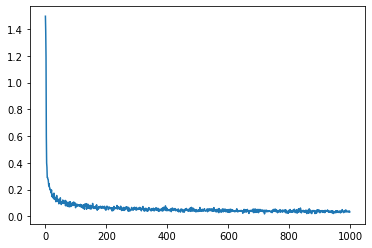

In [27]:
plt.plot(train_loss)

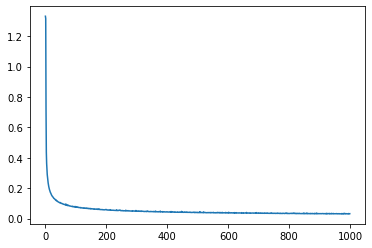

In [28]:
plt.plot(valid_loss)

In [29]:
with tch.no_grad():
    for X, X_p, y in test_dataloader:
        X, X_p, y = X.to(device), X_p.to(device), y.to(device)
        pred1, pred2 = net(X, X_p)
        data = tch.column_stack([pred1, pred2, y])
        print(data[:10,:])
        break

tensor([[125.8254, 125.8127,   0.0000],
        [ 96.3053,  96.2040,   0.0000],
        [163.6914, 163.7336,   0.0000],
        [149.4538, 120.3143,   1.0000],
        [180.6239, 180.5876,   0.0000],
        [317.3731, 317.4455,   0.0000],
        [ 60.7838, 130.9491,   1.0000],
        [154.3404, 154.2888,   0.0000],
        [116.2906, 116.3328,   0.0000],
        [ 59.5121,  59.5091,   0.0000]])


In [32]:
tch.save(net, "../tbin/snn_rot4.pt")